# `CLOUD.jl` - 2D linear advection

In [109]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgsem_2D/"
results_path = "../results/advection_dgsem_2D/";

Define the physical problem

In [110]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a DGSEM scheme of degree `p` with `M` elements

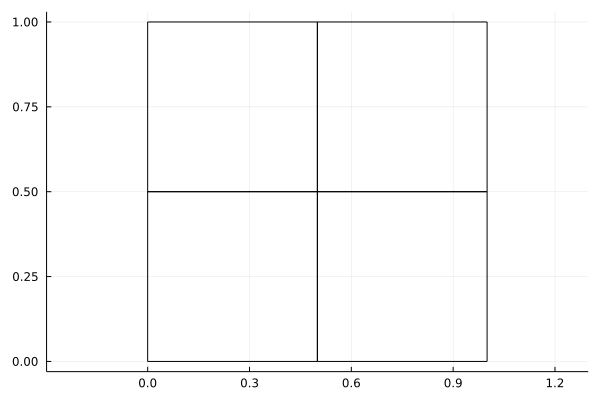

In [111]:
M = 2  # number of elements
p = 4  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Quad(), N_plot=ceil(Int,50/M), sum_factorize=false);
spatial_discretization = SpatialDiscretization(
    uniform_periodic_mesh(reference_approximation.reference_element, 
        ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data,
     WeakConservationForm(), (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf")

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [112]:
reset_timer!()
n_s = 10
dt_scale=0.1
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            144ms / 82.9%           54.5MiB / 94.4%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   1.03k    119ms   100%   116μs   51.5MiB  100%   51.2KiB
   eval flux            4.12k   38.6ms  32.4%  9.37μs   5.16MiB  10.0%  1.28KiB
   eval residual        4.12k   27.1ms  22.8%  6.58μs   25.9MiB  50.3%  6.44KiB
   extrapolate solu...  4.12k   6.48ms  5.45%  1.57μs   2.26MiB  4.40%     576B
   eval numerical flux  4.12k   5.48ms  4.60%  1.33μs   11.4MiB  22.2%  2.84KiB
   gather external ...  4.12k   2.38ms  2.00%   578ns   5.72MiB  11.1%  1.42KiB
 ──────────────────────────────────────

Visualize the solution

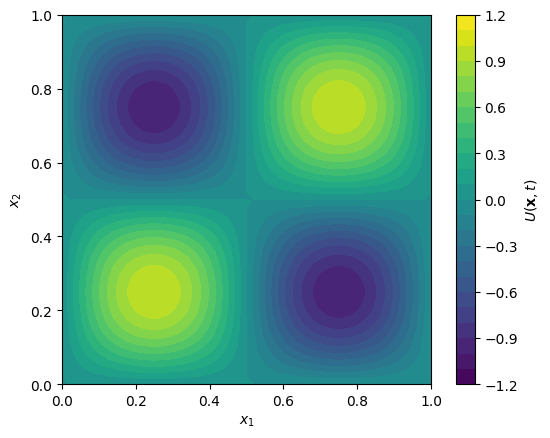

In [113]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

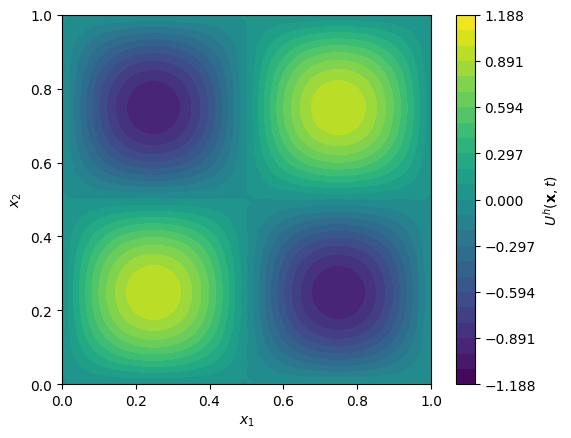

In [114]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm

In [115]:
error_analysis = ErrorAnalysis(conservation_law, spatial_discretization, results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])

L2 error: 0.004886216027850506

In [116]:
x = ones(16,16)
y = similar(x)
y = mul!(y,reference_approximation.D[2],x)

LoadError: DimensionMismatch("A has size (25,25), B has size (16,16), C has size (16, 16)")

In [ ]:
reference_approximation.reference_element.rstf[1]